In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn


In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
iris = load_iris()
X, y = iris.data, iris.target

In [10]:
X.shape, X[0:5], y.shape, y[0:5]

((150, 4),
 array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2]]),
 (150,),
 array([0, 0, 0, 0, 0]))

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

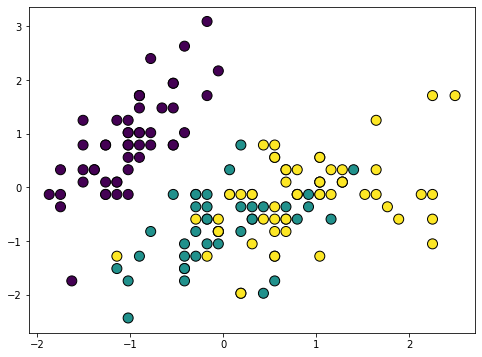

In [22]:
#X[:, 0] extracts the first feature from all data points, X[:, 1] extracts the second feature from all data points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=100)
plt.show()

In [23]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
class BNN(nn.Module):
    def __init__(self):
        super(BNN, self).__init__()
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=16)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=16)
        self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [75]:
model = BNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
kl_weight = 0.01  # KL divergence weight for Bayesian layers

In [76]:
losses=[]
epochs = 300
for epoch in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train) 
    kl_loss = bnn.functional.bayesian_kl_loss(model.fc1) + bnn.functional.bayesian_kl_loss(model.fc2) + bnn.functional.bayesian_kl_loss(model.fc3)
    
    total_loss = loss + kl_weight * kl_loss
    
    losses.append(loss.detach().numpy())
    
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/300], Loss: 1.2039
Epoch [10/300], Loss: 0.9040
Epoch [20/300], Loss: 0.5168
Epoch [30/300], Loss: 0.4113
Epoch [40/300], Loss: 0.2822
Epoch [50/300], Loss: 0.2433
Epoch [60/300], Loss: 0.2066
Epoch [70/300], Loss: 0.1668
Epoch [80/300], Loss: 0.1586
Epoch [90/300], Loss: 0.1498
Epoch [100/300], Loss: 0.1839
Epoch [110/300], Loss: 0.0997
Epoch [120/300], Loss: 0.1363
Epoch [130/300], Loss: 0.1255
Epoch [140/300], Loss: 0.1223
Epoch [150/300], Loss: 0.1872
Epoch [160/300], Loss: 0.0788
Epoch [170/300], Loss: 0.0905
Epoch [180/300], Loss: 0.0920
Epoch [190/300], Loss: 0.0922
Epoch [200/300], Loss: 0.1036
Epoch [210/300], Loss: 0.0820
Epoch [220/300], Loss: 0.0836
Epoch [230/300], Loss: 0.1007
Epoch [240/300], Loss: 0.1089
Epoch [250/300], Loss: 0.1158
Epoch [260/300], Loss: 0.0970
Epoch [270/300], Loss: 0.0921
Epoch [280/300], Loss: 0.0900
Epoch [290/300], Loss: 0.0773


In [98]:
model.eval()
with torch.no_grad():
    num_samples = 100
    y_pred_samples = []
    
    for _ in range(num_samples):
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        y_pred_samples.append(predicted)
        
    y_pred_samples = torch.stack(y_pred_samples).numpy()
    
    accuracies = [accuracy_score(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)]
    mean_accuracy = np.mean(accuracies)
    uncertainty_accuracy = np.std(accuracies)
    
    mean_confusion_matrix = np.mean([confusion_matrix(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)], axis=0)
    uncertainty_confusion_matrix = np.std([confusion_matrix(y_test.numpy(), y_pred_samples[i]) for i in range(num_samples)], axis=0)

    
print()  
print(f"Mean Accuracy: {mean_accuracy*100:.2f}%")
print(f"Accuracy Uncertainty: {uncertainty_accuracy*100:.2f}%")

0.9777777777777777

Mean Accuracy: 99.16%
Accuracy Uncertainty: 1.08%


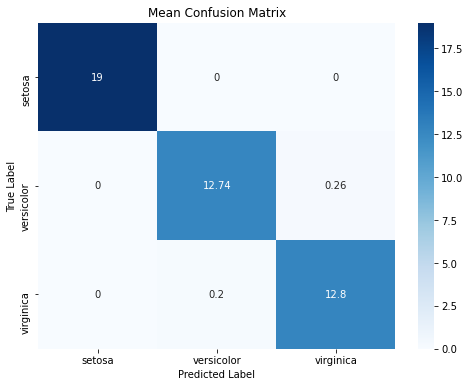

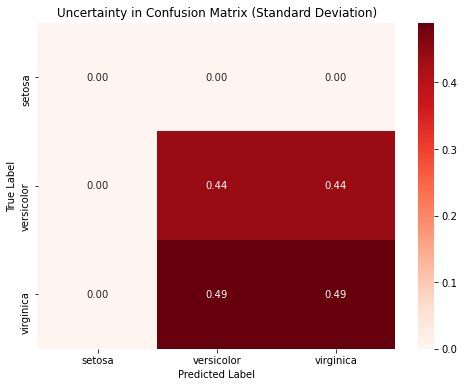

In [85]:
plt.figure(figsize=(8, 6))
sns.heatmap(mean_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Mean Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot heatmap for uncertainty (standard deviation) in confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(uncertainty_confusion_matrix, annot=True, fmt='.2f', cmap='Reds', cbar=True, xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title('Uncertainty in Confusion Matrix (Standard Deviation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

64
256


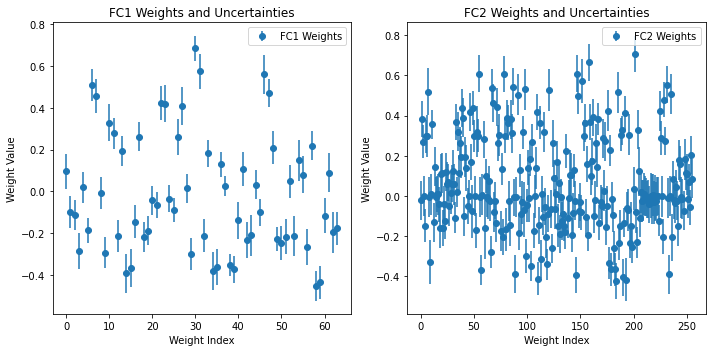

In [99]:
with torch.no_grad():
    fc1_weights = model.fc1.weight_mu.flatten().numpy()
    fc1_weights_log_sigma = model.fc1.weight_log_sigma.flatten().numpy()
    fc1_weights_std = np.exp(fc1_weights_log_sigma)  # Convert log_sigma to sigma
    
    # Retrieve weights and standard deviations from layer 2 (FC2)
    fc2_weights = model.fc2.weight_mu.flatten().numpy()
    fc2_weights_log_sigma = model.fc2.weight_log_sigma.flatten().numpy()
    fc2_weights_std = np.exp(fc2_weights_log_sigma)  # Convert log_sigma to sigma
    
    
    print(len(fc1_weights))
    print(len(fc2_weights))
    

    # Plotting weights with error bars
    plt.figure(figsize=(10, 5))
    
    # Plot FC1 weights and uncertainties
    plt.subplot(1, 2, 1)
    plt.errorbar(range(len(fc1_weights)), fc1_weights, yerr=fc1_weights_std, fmt='o', label='FC1 Weights')
    plt.title('FC1 Weights and Uncertainties')
    plt.xlabel('Weight Index')
    plt.ylabel('Weight Value')
    plt.legend()
    
    # Plot FC2 weights and uncertainties
    plt.subplot(1, 2, 2)
    plt.errorbar(range(len(fc2_weights)), fc2_weights, yerr=fc2_weights_std, fmt='o', label='FC2 Weights')
    plt.title('FC2 Weights and Uncertainties')
    plt.xlabel('Weight Index')
    plt.ylabel('Weight Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
"""

If kl_weight = 0.1, the model accuracy is lower. However, When I remove the Kl lose or reduce the kl_weight to 0.01, 
the accurcay is high. This may be because of a few reasons

1) Trade-off Between Uncertainty and Accuracy:

. The Kl divergence term encourages the model to stay close to the prior distribution (which we place as a normal distribution)
  adding regularization to the model. This prevents the model from ovverfitting by introducing uncertainty in the weights, 
  which can result in slightly higher bias (lower accuracy) in the short term, especially during training.
  
  If we remove the KL lose, the model behaves more like a deterministic (standard) neural network. It focuses mainly on
  minimizing the classification error, potentially leading to higher accuracy during training but a higher risk of overfitting
  
  
2) Effect of Regularization

. The Kl term acts as a regularizer by penalizing large diviations of the learned weigths from the prior distribution.
  This helps the network generalize better, especially on unseen data. However, in the early stages of training 
  (and on small datasets like Iris), this regularization can slow down convergence, causing lower accuracy initially.
  
  Without KL loss, the model may overfit the training data more easily, leading to higher accuracy during training and
  on in-sample validation, but potentially poorer generalization to the new dataset
  

3) Small Dataset Effect (Iris Dataset):

. On small datasets like Iris, regularization (via the KL term) may have a more pronounced impact becuase there isn’t as 
  much data for the network to learn fine details. The network might prioritize generalization too much, 
  which can reduce accuracy on such a small dataset. On larger datasets, this trade-off tends to favor KL regularization, 
  leading to better generalization.
  
  
4) KL Weight:

. The kl_weight parameter plays an important role in balancing the trade-off. A 'Larger' kl_weight value will emphasize
  regularization, making the model more cautious (and less accurate in the short term). On the other hand, a smaller 
  Kl weight will allow the model to focus more on fitting the data.
  
  Note: An increase in accuracy is seen when the kl_weight is tuned from 0.1 to 0.01. kl_weight as low as 0.001 is possible
  however this will lead to poor generalization and prone to overfitting. 



"""


"""

Handling the trade off

1. Adjust the kl_weight to balance between classification accuracy and uncertainty. Smaller values will have less 
   regularization effect and might improve accuracy without losing the benefits of Bayesian modeling.
   
   
2. Evaluate on Unseen Data: Check the model’s performance on truly unseen test data. 
   Models with KL regularization often perform better in generalization, even if the training or validation accuracy is 
   lower.


"""